In [3]:
pip install ucimlrepo

In [4]:
# (i) Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from ucimlrepo import fetch_ucirepo

In [5]:
# (ii) Load dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

df = pd.concat([X, y], axis=1)

df.to_csv("breast_cancer_wisconsin_diagnostic.csv", index=False)

target = 'Diagnosis'

In [6]:
# (iii) EDA and Preprocessing

def is_normal(series):
    skew = series.skew()
    return -0.5 <= skew <= 0.5

def has_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()
    return outliers > 0

In [7]:
# Separate types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target]

# --- Missing Values Handling ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in numerical_cols:
            if is_normal(df[col]):
                if has_outliers(df[col]):
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)  # categorical

# --- Outlier Replacing (for numerical columns only) ---
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if is_normal(df[col]):
        replacement_value = df[col].mean()
    else:
        replacement_value = df[col].median()

    # Replace outliers
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), replacement_value, df[col])

In [8]:
# --- Drop rows where target is missing ---
df.dropna(subset=[target], inplace=True)

# --- Feature Engineering (if needed) ---
df["circularity1"] = 4 * np.pi * df["area1"] / (df["perimeter1"] ** 2 + 1e-6)
df["area_per_radius1"] = df["area1"] / (df["radius1"] + 1e-6)

In [9]:
# --- Encoding categorical features ---
is_classification = True

if is_classification:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])  # encode target
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])  # label encoding for classification
else:
    # Regression: target guided ordinal encoding
    for col in categorical_cols:
        ordered_labels = df.groupby(col)[target].mean().sort_values().index
        mapping = {k: i for i, k in enumerate(ordered_labels)}
        df[col] = df[col].map(mapping)

In [10]:
'''# --- Scaling ---
for col in numerical_cols:
    if is_normal(df[col]):
        scaler = StandardScaler()
    elif has_outliers(df[col]):
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    df[[col]] = scaler.fit_transform(df[[col]])'''

df.to_csv("updated_diagnosis.csv", index=False)

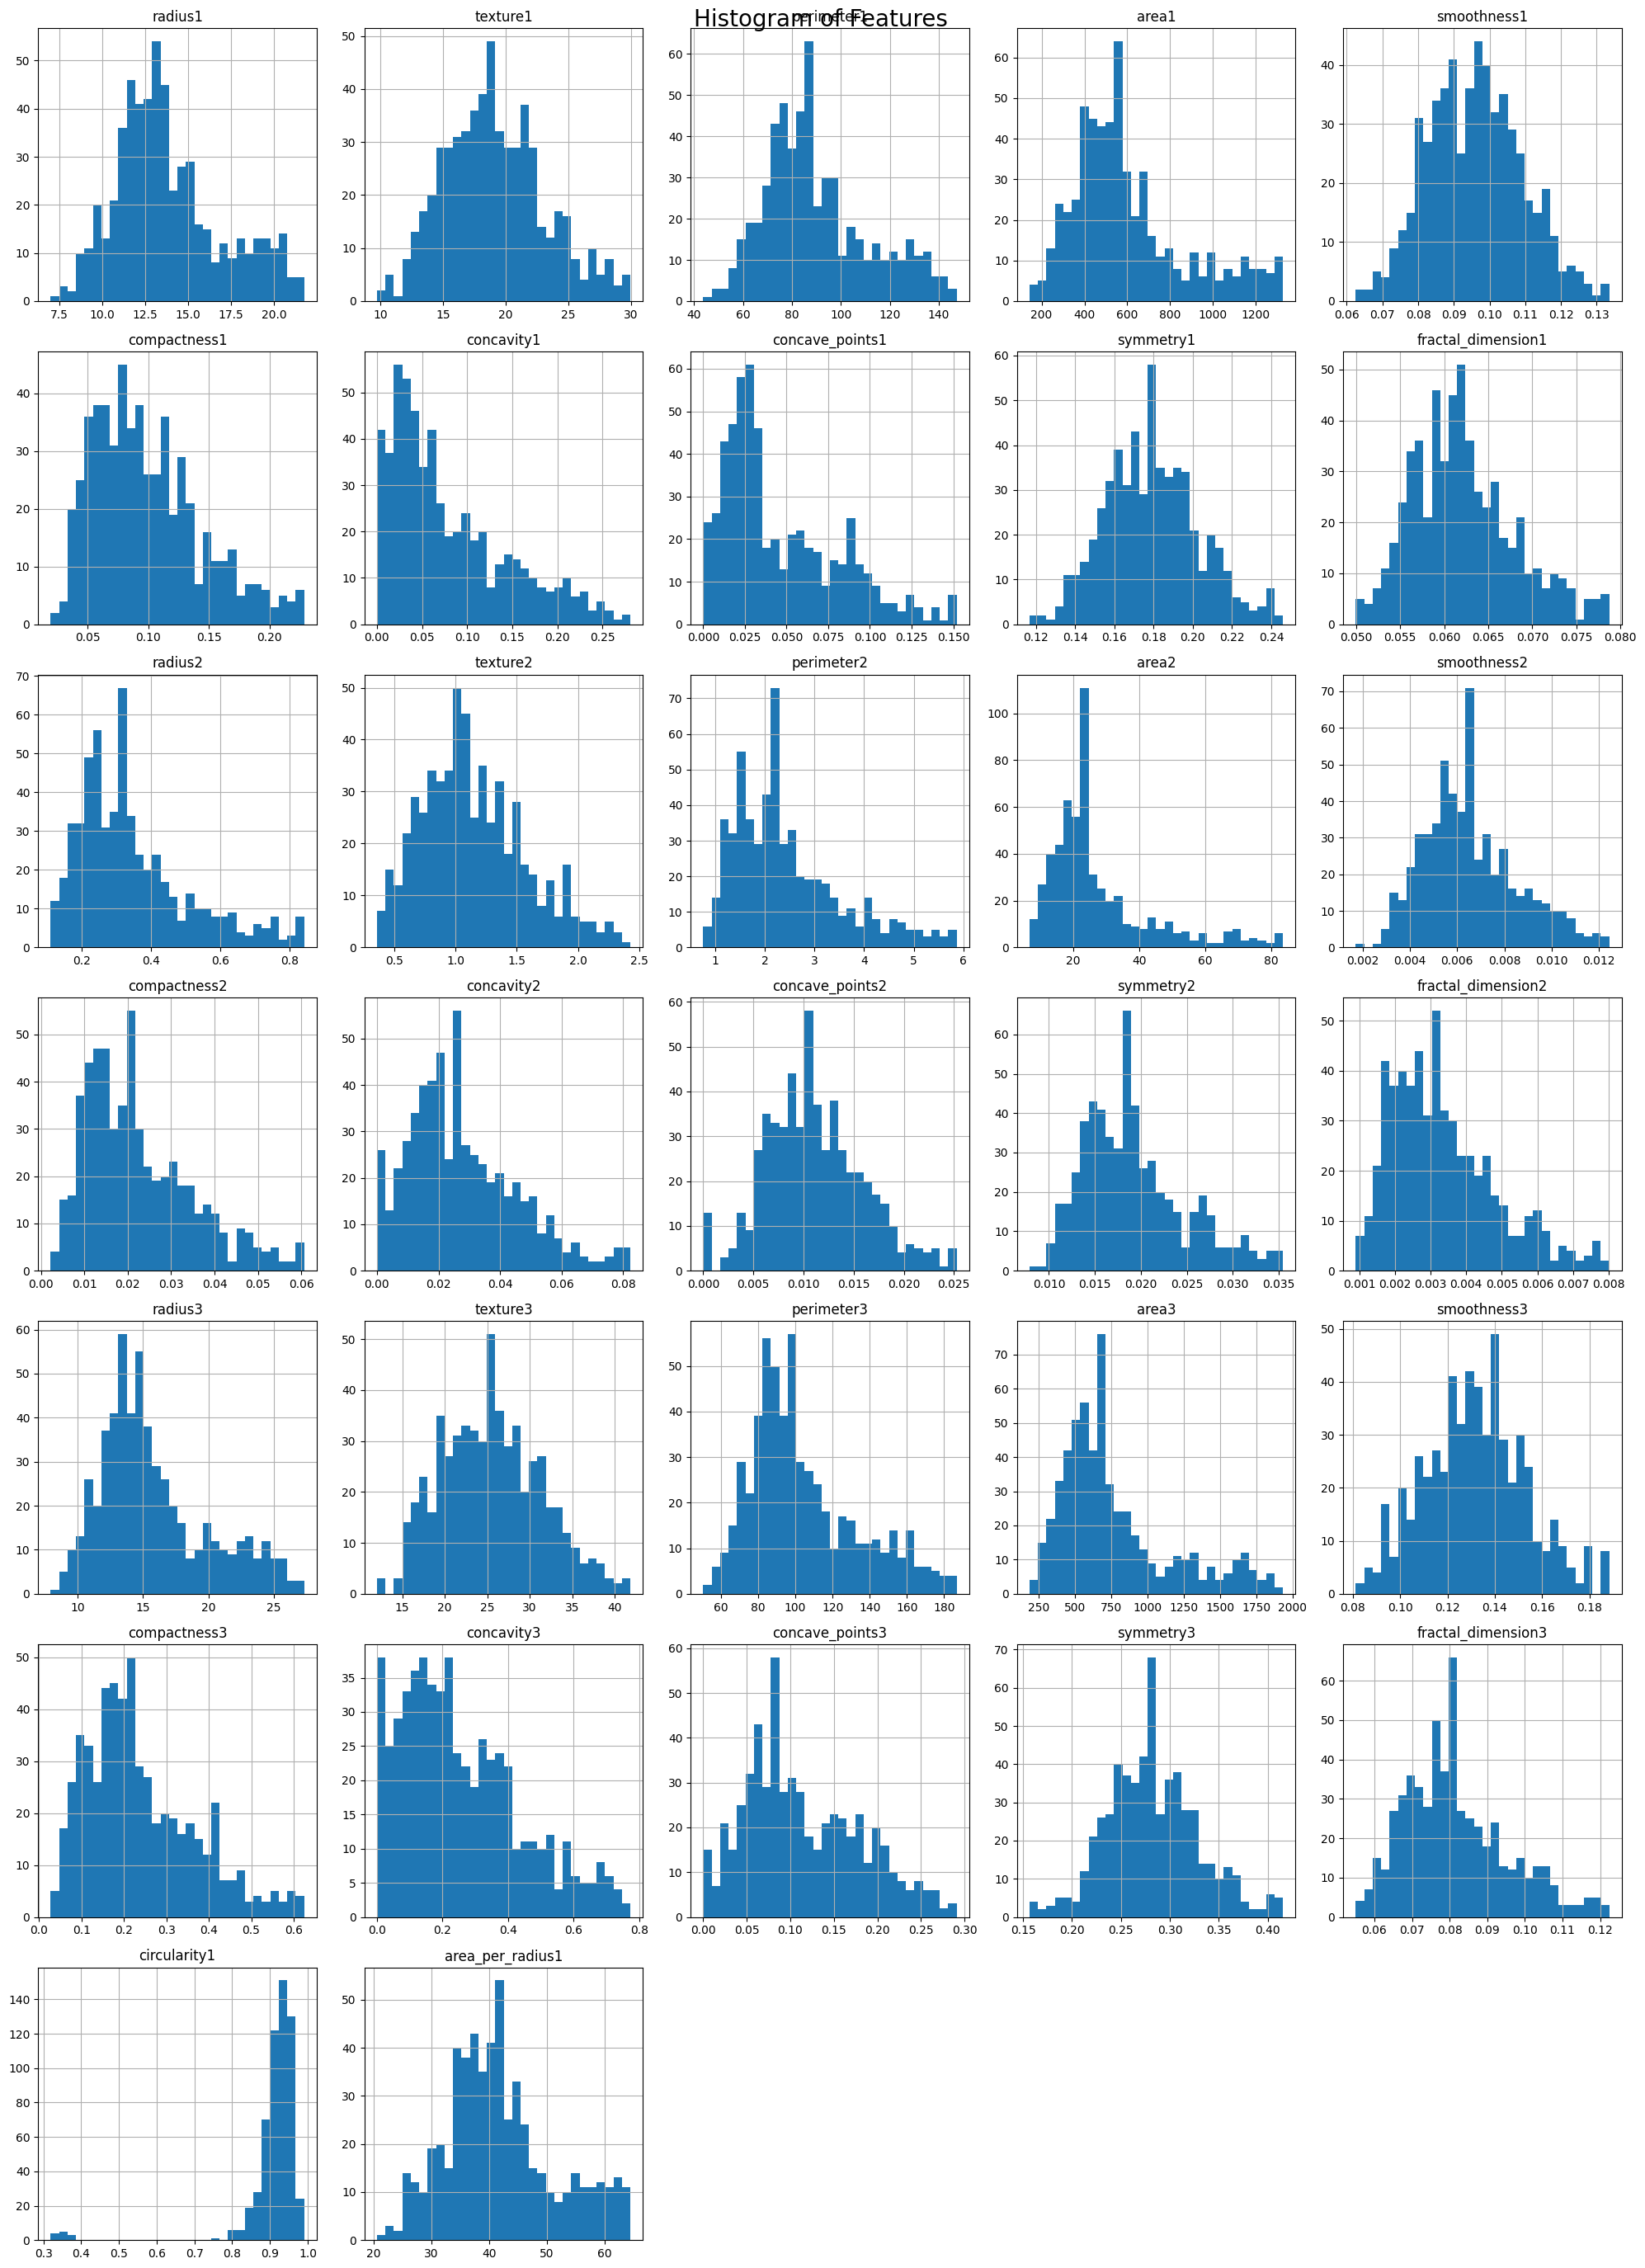

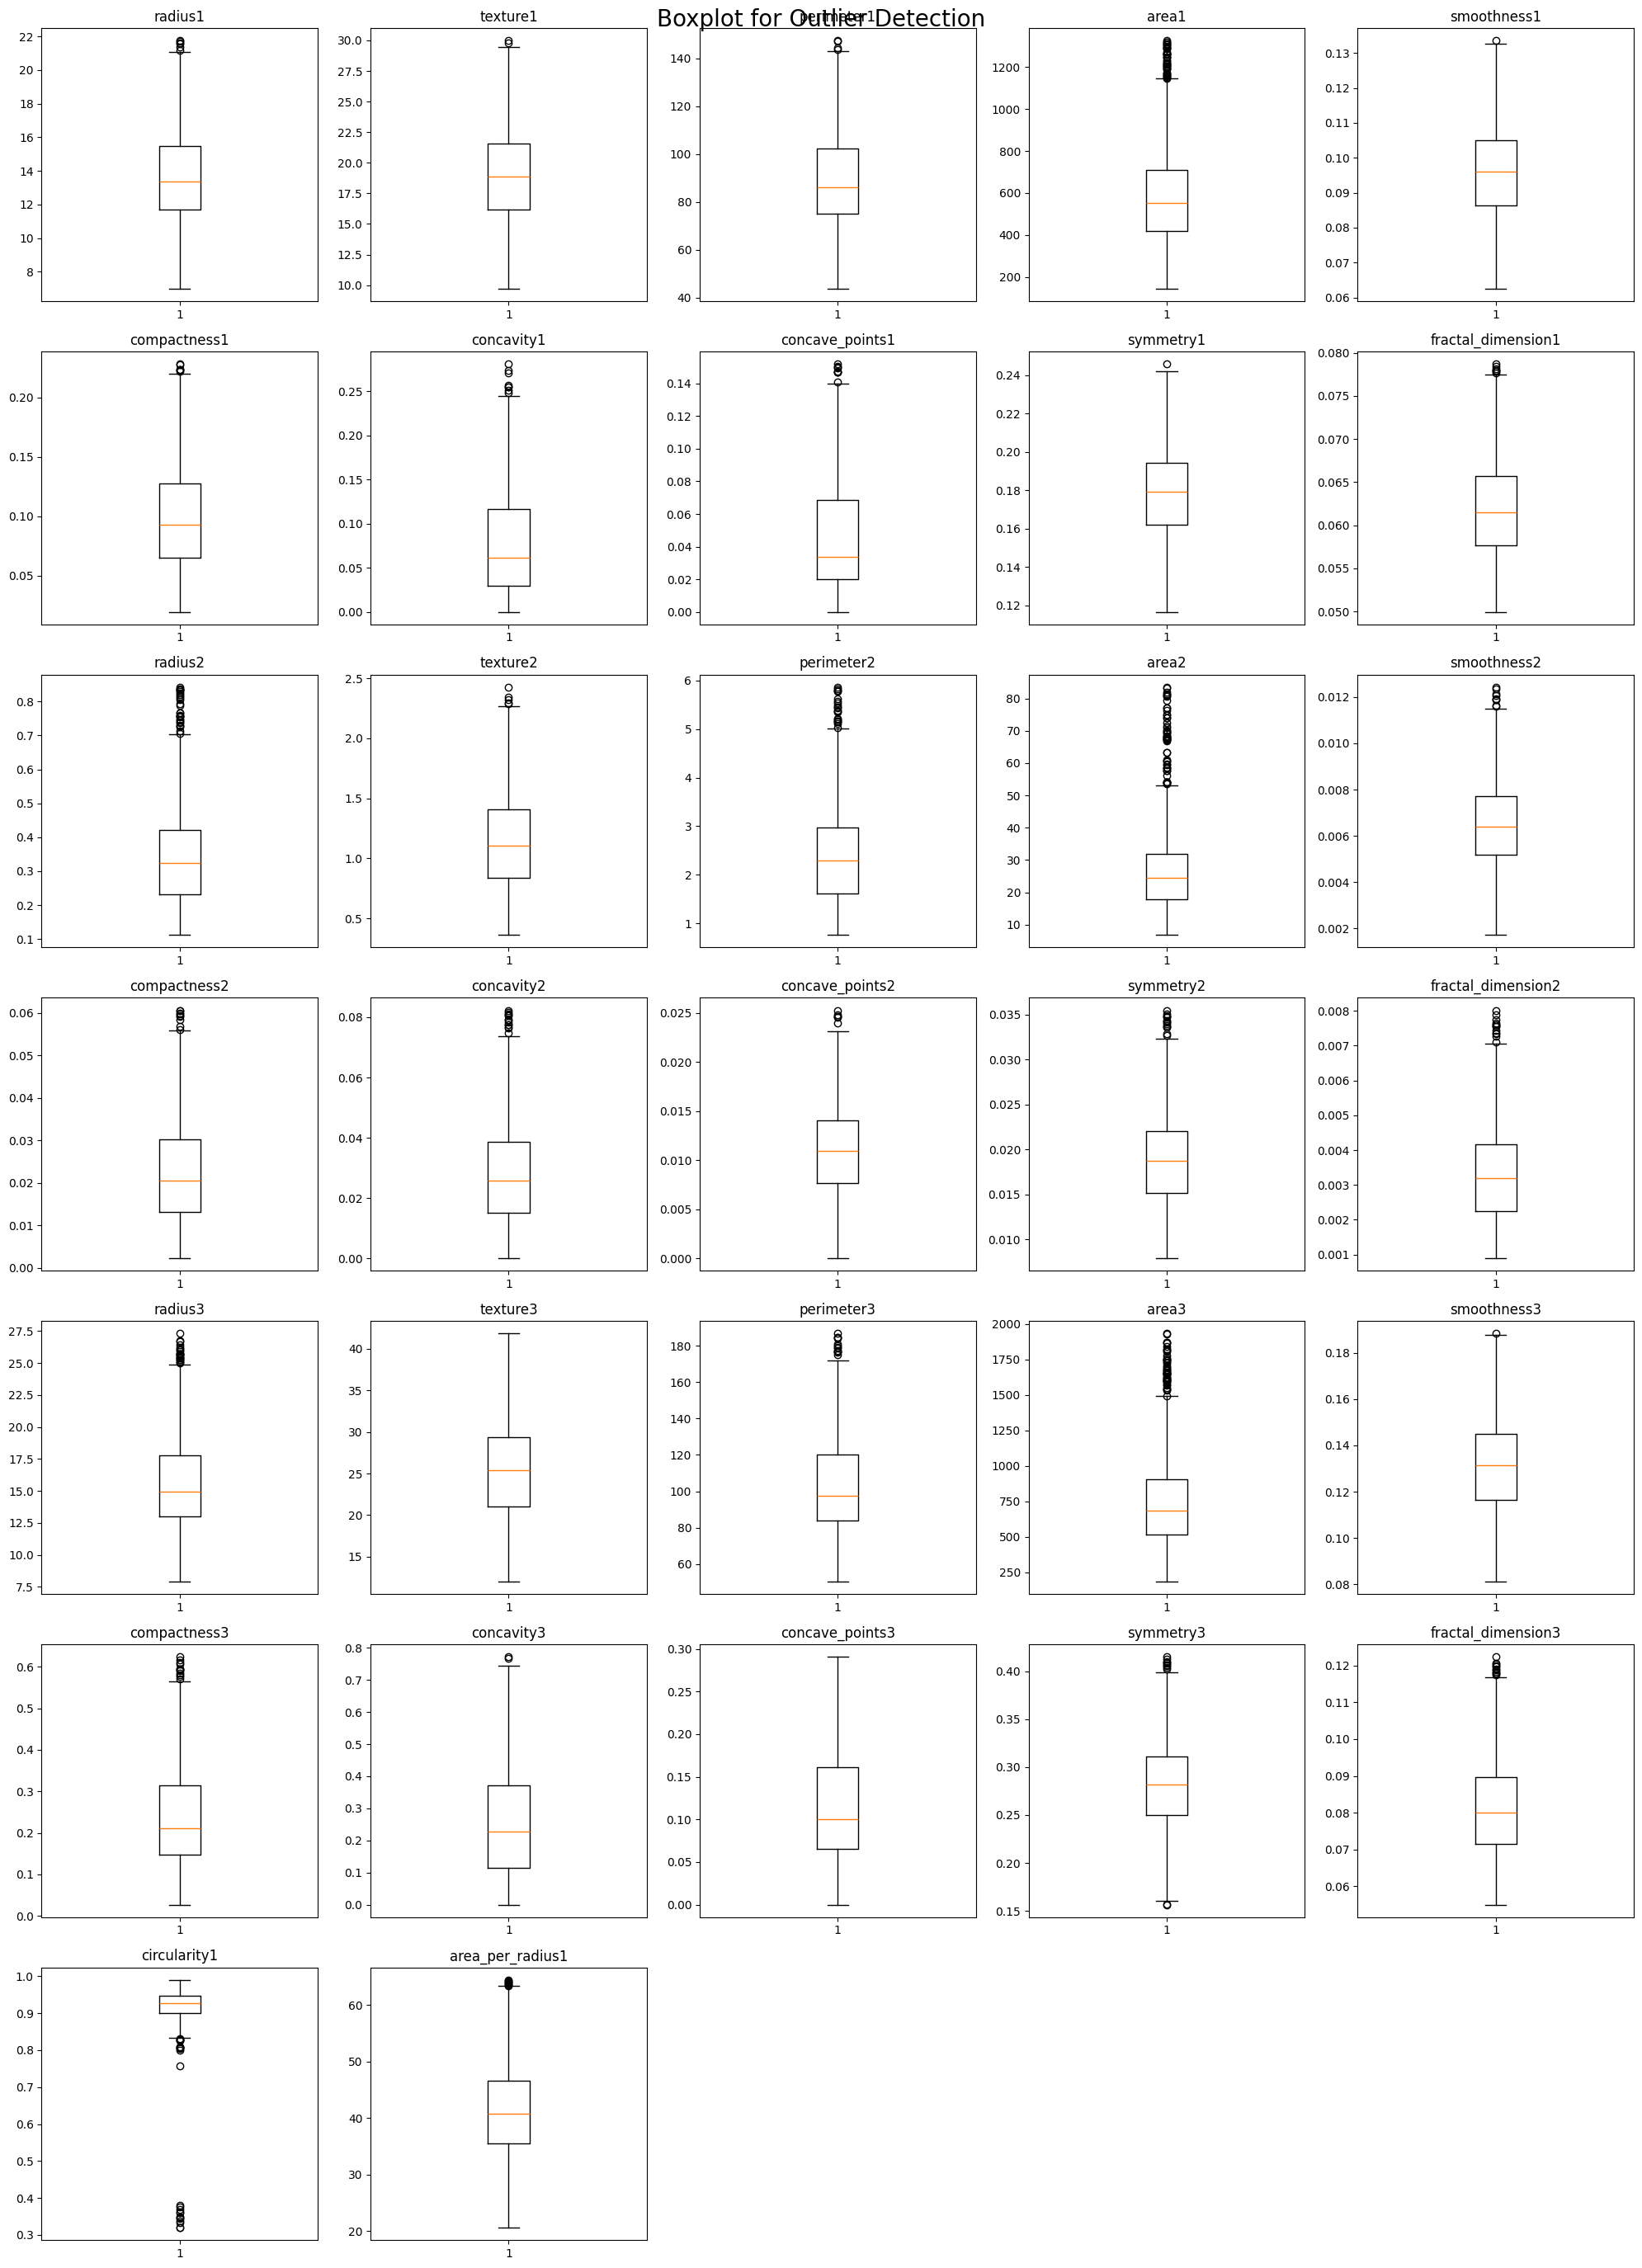

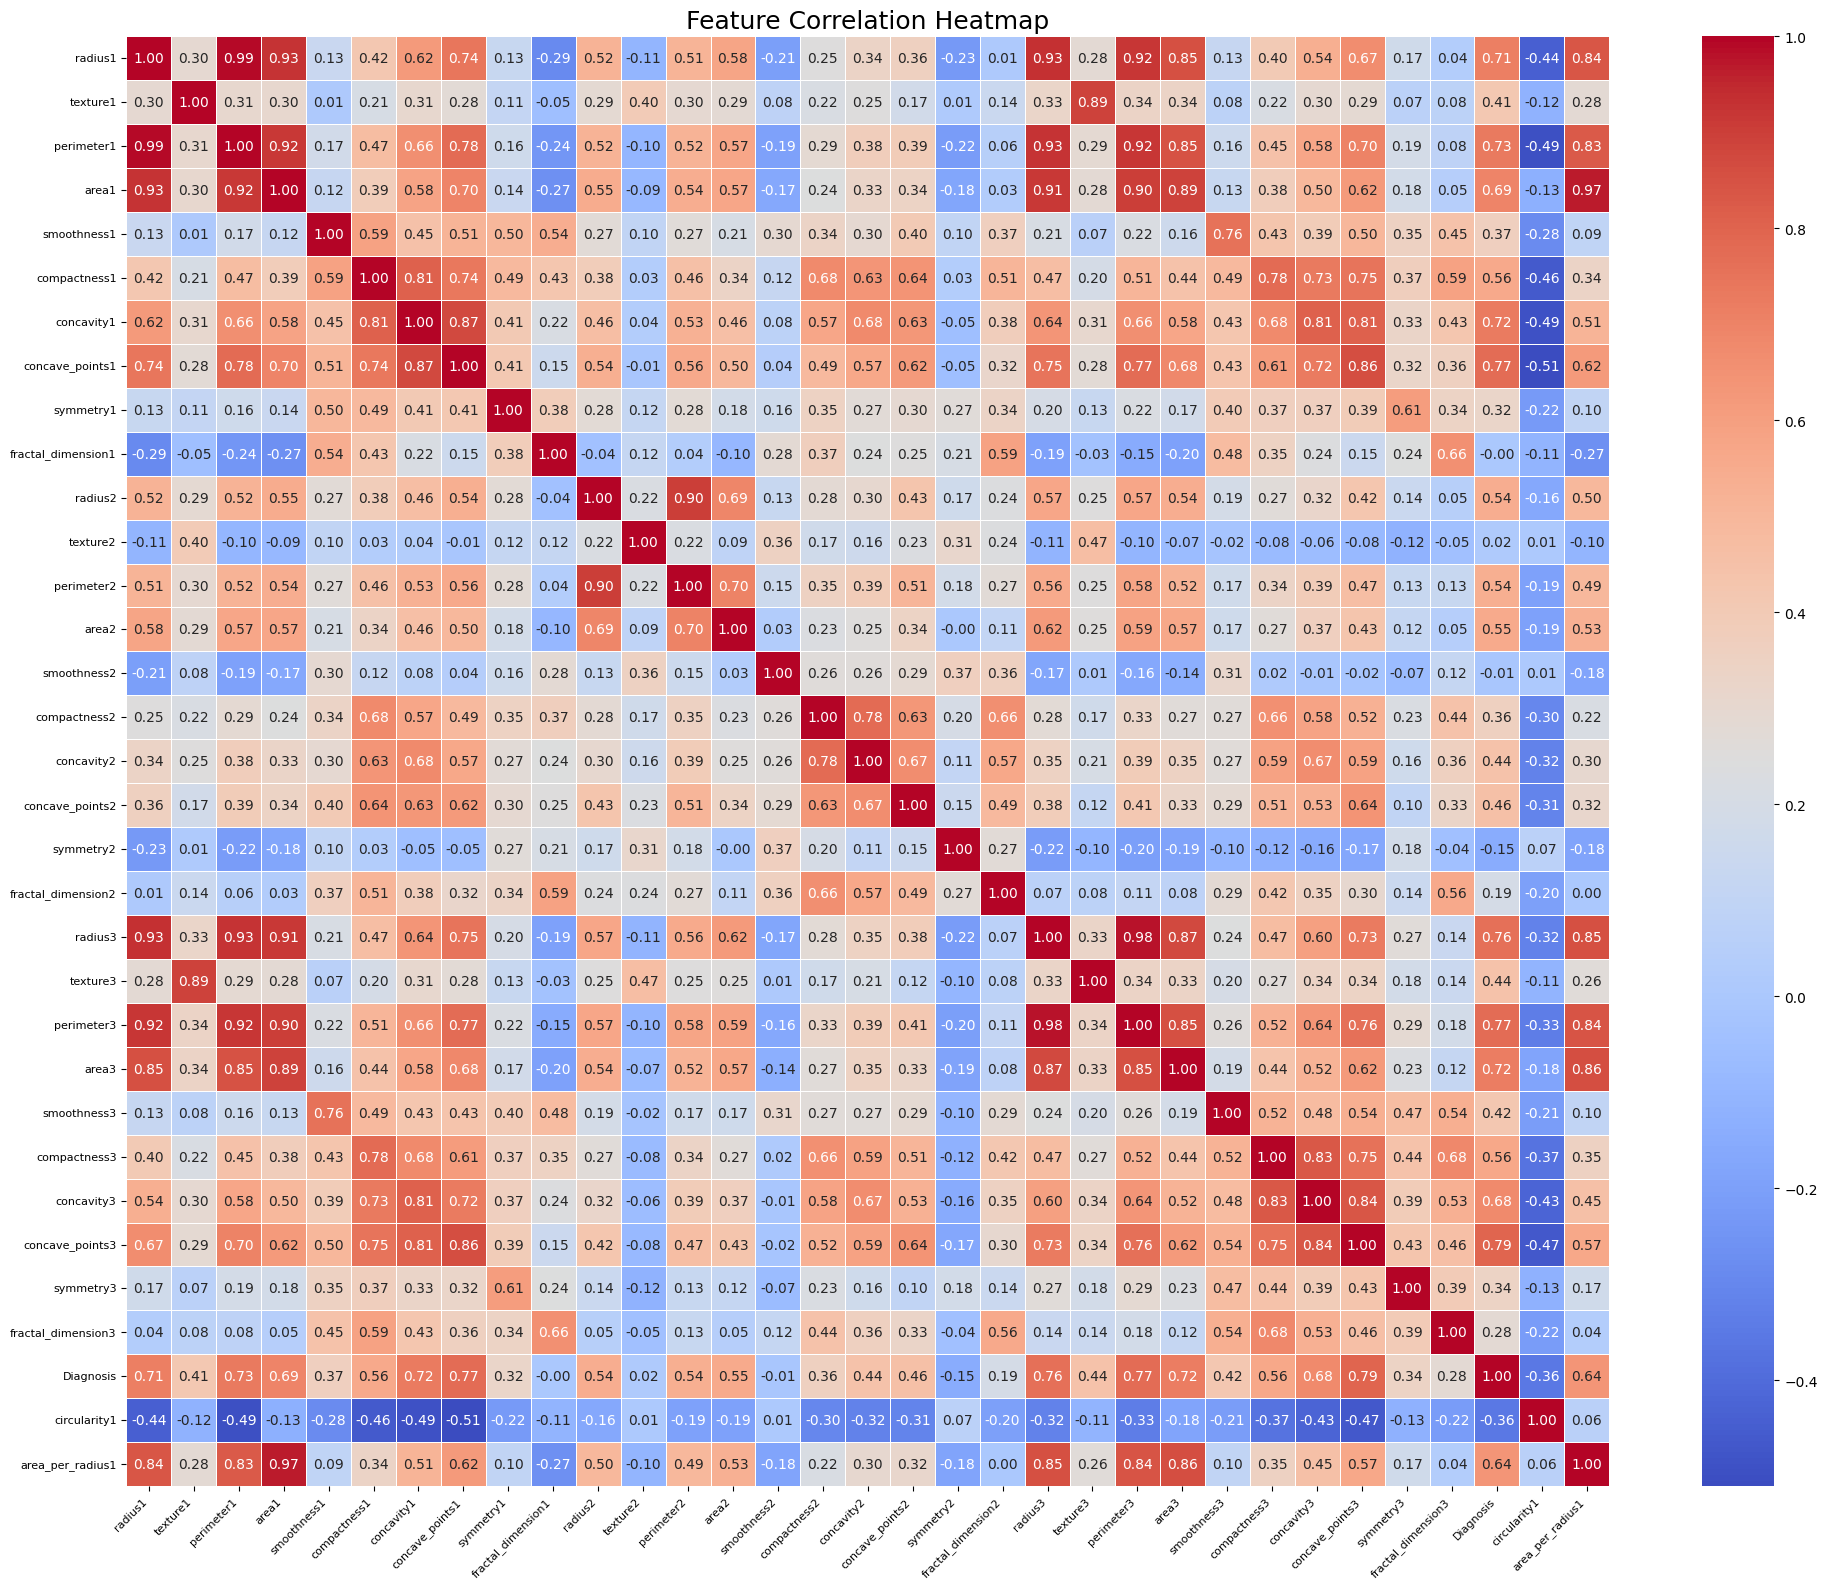

In [11]:
# --- Histogram Subplots ---
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target]
n_cols = 5  # Number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col)

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Histogram of Features", fontsize=20)
plt.tight_layout()
plt.show()

# --- Boxplot Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplot for Outlier Detection", fontsize=20)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [12]:
# (iv) Splitting dataset

X = df.drop(columns=[target])
y = df[target]

# Splitting: Train (60%), Validation (20%), Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}')

Train: (341, 32), Validation: (114, 32), Test: (114, 32)


In [13]:
# Store results
best_models = {}
y_val_preds = {}
y_test_preds = {}

# Common scoring metric
scoring = 'accuracy'

# ---------- Decision Tree ----------
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5, 10]
}
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_dt, cv=5, scoring=scoring, n_jobs=-1
)
grid_dt.fit(X_train, y_train)
model_dt = grid_dt.best_estimator_
y_val_dt = model_dt.predict(X_val)
y_test_dt = model_dt.predict(X_test)

best_models['DecisionTree'] = model_dt
y_val_preds['DecisionTree'] = y_val_dt
y_test_preds['DecisionTree'] = y_test_dt

# ---------- Random Forest ----------
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_rf, cv=5, scoring=scoring, n_jobs=-1
)
grid_rf.fit(X_train, y_train)
model_rf = grid_rf.best_estimator_
y_val_rf = model_rf.predict(X_val)
y_test_rf = model_rf.predict(X_test)

best_models['RandomForest'] = model_rf
y_val_preds['RandomForest'] = y_val_rf
y_test_preds['RandomForest'] = y_test_rf

# ---------- AdaBoost ----------
param_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator': [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=3)
]

}
grid_ab = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_ab, cv=5, scoring=scoring, n_jobs=-1
)
grid_ab.fit(X_train, y_train)
model_ab = grid_ab.best_estimator_
y_val_ab = model_ab.predict(X_val)
y_test_ab = model_ab.predict(X_test)

best_models['AdaBoost'] = model_ab
y_val_preds['AdaBoost'] = y_val_ab
y_test_preds['AdaBoost'] = y_test_ab

# ---------- Gradient Boost ----------
param_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}
grid_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_gb, cv=5, scoring=scoring, n_jobs=-1
)
grid_gb.fit(X_train, y_train)
model_gb = grid_gb.best_estimator_
y_val_gb = model_gb.predict(X_val)
y_test_gb = model_gb.predict(X_test)

best_models['GradientBoost'] = model_gb
y_val_preds['GradientBoost'] = y_val_gb
y_test_preds['GradientBoost'] = y_test_gb

# ---------- XGBoost ----------
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 5]
}
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_xgb, cv=5, scoring=scoring, n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
model_xgb = grid_xgb.best_estimator_
y_val_xgb = model_xgb.predict(X_val)
y_test_xgb = model_xgb.predict(X_test)

best_models['XGBoost'] = model_xgb
y_val_preds['XGBoost'] = y_val_xgb
y_test_preds['XGBoost'] = y_test_xgb


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:01:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
def tune_svm(X_train, y_train):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(probability=True, random_state=42))
    ])

    param_grid = {
        "svm__kernel": ["linear", "rbf", "poly"],
        "svm__C": [0.1, 1, 10],
        "svm__gamma": ["scale", "auto"]
    }

    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best SVM Params:", grid.best_params_)
    return grid.best_estimator_

best_svm = tune_svm(X_train, y_train)
nb_model = GaussianNB()
dt_model = best_models['DecisionTree']  # reuse tuned one
rf_model = best_models['RandomForest']  # reuse tuned one
knn_model = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

stack1 = StackingClassifier(
    estimators=[("svm", best_svm), ("nb", nb_model), ("dt", dt_model)],
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=5,
    n_jobs=-1
)

stack2 = StackingClassifier(
    estimators=[("svm", best_svm), ("nb", nb_model), ("dt", dt_model)],
    final_estimator=RandomForestClassifier(n_estimators=200, random_state=42),
    cv=5,
    n_jobs=-1
)

stack3 = StackingClassifier(
    estimators=[("svm", best_svm), ("dt", dt_model), ("knn", knn_model)],
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=5,
    n_jobs=-1
)

for name, model in {
    "Stacked_LogReg": stack1,
    "Stacked_RF": stack2,
    "Stacked_LogReg_KNN": stack3
}.items():
    model.fit(X_train, y_train)
    y_val_preds[name] = model.predict(X_val)
    y_test_preds[name] = model.predict(X_test)
    best_models[name] = model

Best SVM Params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [15]:
for i in best_models:
  print(i, best_models[i].get_params(), '\n')

DecisionTree {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'} 

RandomForest {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 

AdaBoost {'algorithm': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decr


==================== DecisionTree - Validation ====================

 Evaluation - DecisionTree (Validation)
Accuracy : 0.9474
Precision: 0.9485
Recall   : 0.9474
F1 Score : 0.9476

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        72
           1       0.91      0.95      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

ROC AUC Score: 0.977


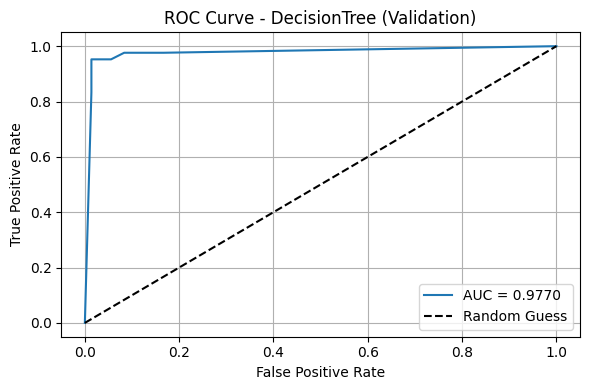


==================== DecisionTree - Test ====================

 Evaluation - DecisionTree (Test)
Accuracy : 0.9298
Precision: 0.9313
Recall   : 0.9298
F1 Score : 0.9303

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95        76
           1       0.88      0.92      0.90        38

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.92       114
weighted avg       0.93      0.93      0.93       114

ROC AUC Score: 0.952


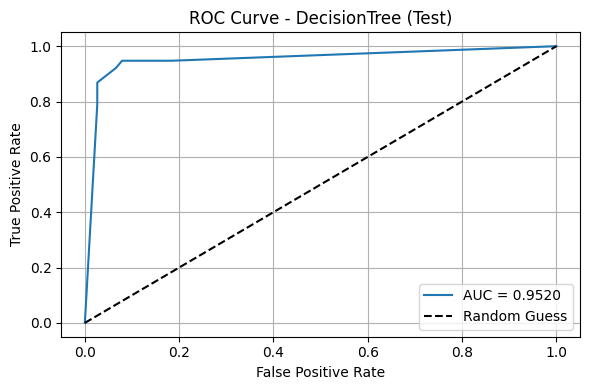


==================== RandomForest - Validation ====================

 Evaluation - RandomForest (Validation)
Accuracy : 0.9649
Precision: 0.9649
Recall   : 0.9649
F1 Score : 0.9649

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        72
           1       0.95      0.95      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

ROC AUC Score: 0.9967


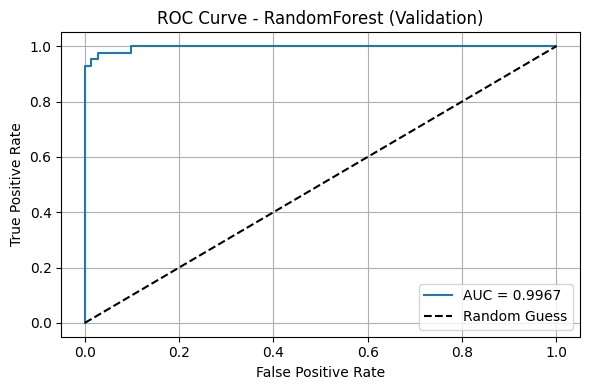


==================== RandomForest - Test ====================

 Evaluation - RandomForest (Test)
Accuracy : 0.9561
Precision: 0.956
Recall   : 0.9561
F1 Score : 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        76
           1       0.95      0.92      0.93        38

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC AUC Score: 0.9962


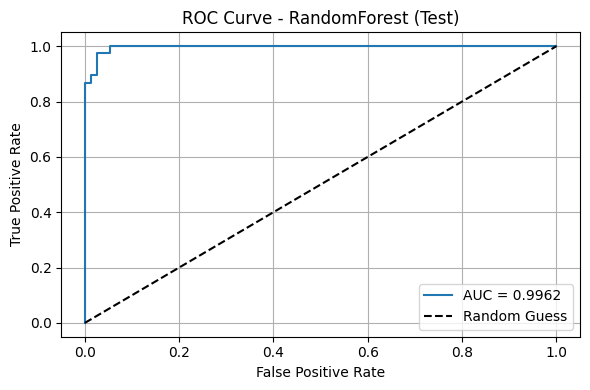


==================== AdaBoost - Validation ====================

 Evaluation - AdaBoost (Validation)
Accuracy : 0.9737
Precision: 0.974
Recall   : 0.9737
F1 Score : 0.9737

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.995


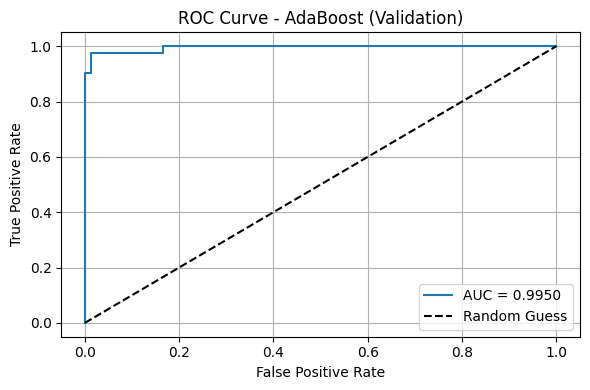


==================== AdaBoost - Test ====================

 Evaluation - AdaBoost (Test)
Accuracy : 0.9649
Precision: 0.966
Recall   : 0.9649
F1 Score : 0.9651

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        76
           1       0.93      0.97      0.95        38

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

ROC AUC Score: 0.9969


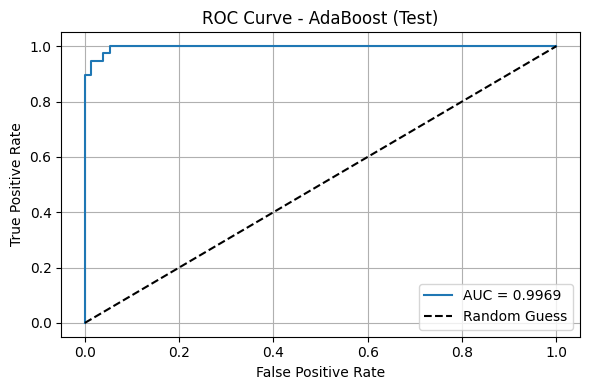


==================== GradientBoost - Validation ====================

 Evaluation - GradientBoost (Validation)
Accuracy : 0.9737
Precision: 0.9737
Recall   : 0.9737
F1 Score : 0.9736

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.996


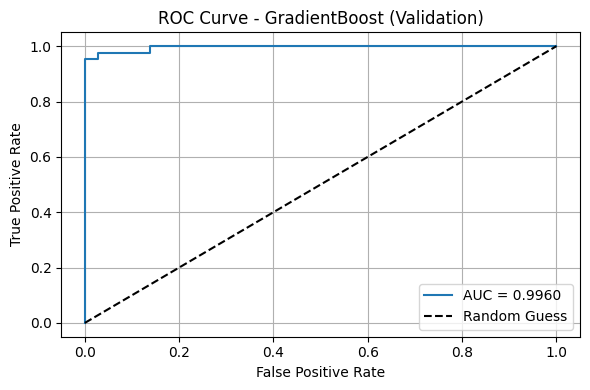


==================== GradientBoost - Test ====================

 Evaluation - GradientBoost (Test)
Accuracy : 0.9561
Precision: 0.956
Recall   : 0.9561
F1 Score : 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        76
           1       0.95      0.92      0.93        38

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC AUC Score: 0.9927


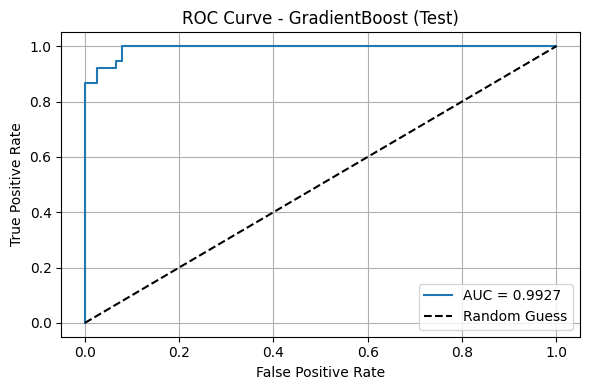


==================== XGBoost - Validation ====================

 Evaluation - XGBoost (Validation)
Accuracy : 0.9737
Precision: 0.9737
Recall   : 0.9737
F1 Score : 0.9736

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9937


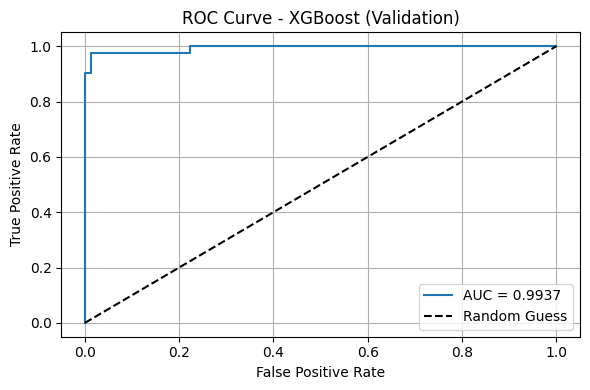


==================== XGBoost - Test ====================

 Evaluation - XGBoost (Test)
Accuracy : 0.9386
Precision: 0.9383
Recall   : 0.9386
F1 Score : 0.9384

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        76
           1       0.92      0.89      0.91        38

    accuracy                           0.94       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC Score: 0.991


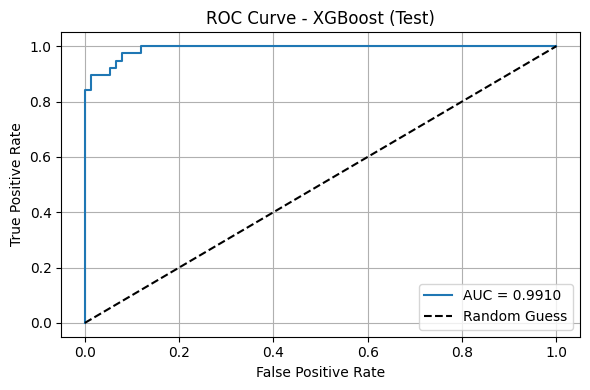


==================== Stacked_LogReg - Validation ====================

 Evaluation - Stacked_LogReg (Validation)
Accuracy : 0.9737
Precision: 0.974
Recall   : 0.9737
F1 Score : 0.9737

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9914


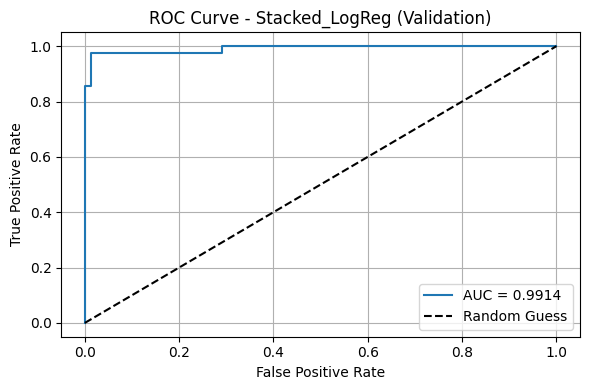


==================== Stacked_LogReg - Test ====================

 Evaluation - Stacked_LogReg (Test)
Accuracy : 0.9737
Precision: 0.9737
Recall   : 0.9737
F1 Score : 0.9736

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        76
           1       0.97      0.95      0.96        38

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9962


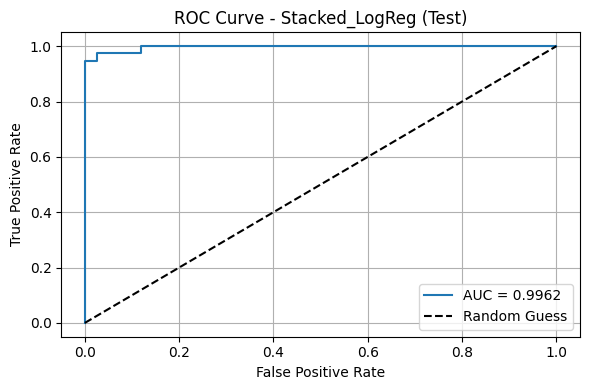


==================== Stacked_RF - Validation ====================

 Evaluation - Stacked_RF (Validation)
Accuracy : 0.9737
Precision: 0.974
Recall   : 0.9737
F1 Score : 0.9737

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9762


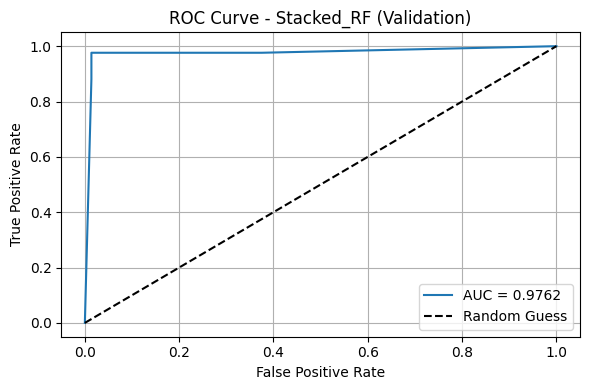


==================== Stacked_RF - Test ====================

 Evaluation - Stacked_RF (Test)
Accuracy : 0.9825
Precision: 0.9825
Recall   : 0.9825
F1 Score : 0.9825

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        76
           1       0.97      0.97      0.97        38

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC Score: 0.9934


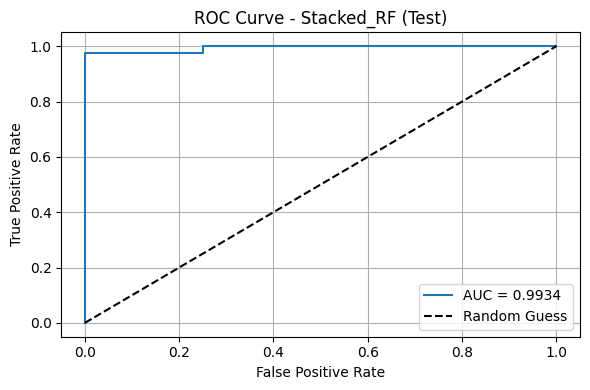


==================== Stacked_LogReg_KNN - Validation ====================

 Evaluation - Stacked_LogReg_KNN (Validation)
Accuracy : 0.9825
Precision: 0.9825
Recall   : 0.9825
F1 Score : 0.9825

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC Score: 0.995


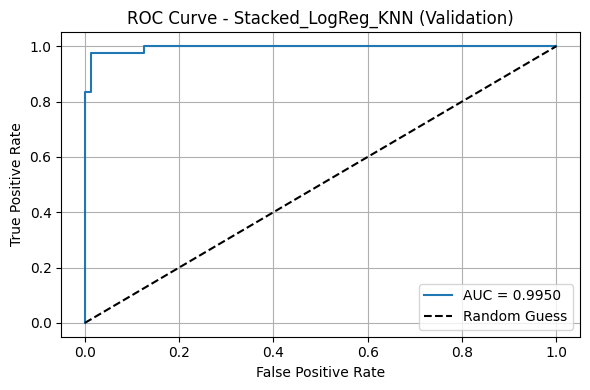


==================== Stacked_LogReg_KNN - Test ====================

 Evaluation - Stacked_LogReg_KNN (Test)
Accuracy : 0.9825
Precision: 0.9825
Recall   : 0.9825
F1 Score : 0.9825

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        76
           1       0.97      0.97      0.97        38

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC Score: 0.9948


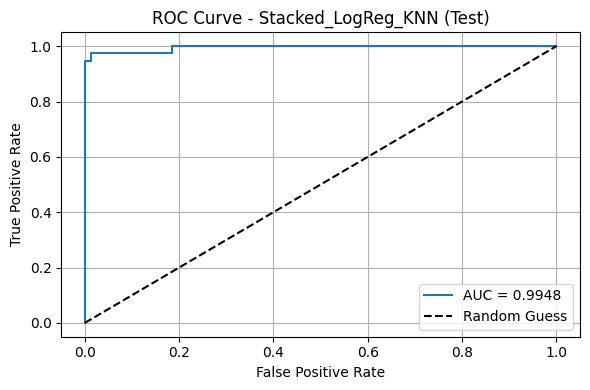

In [16]:
# (vi) Evaluation

# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    if is_classification:
        print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
        print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))
        print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
        print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # ROC Curve: Only for binary classification
        if len(np.unique(y_true)) == 2 and model is not None and hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            auc_score = roc_auc_score(y_true, y_probs)
            print("ROC AUC Score:", round(auc_score, 4))

            # Plot ROC
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {dataset_name}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        n, p = X.shape
        r2 = r2_score(y_true, y_pred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R2 Score:", r2)
        print("Adjusted R2 Score:", adjusted_r2)

for model_name, model in best_models.items():
  print(f"\n{'='*20} {model_name} - Validation {'='*20}")
  evaluate_model(y_val, y_val_preds[model_name], True, X_val, model, f"{model_name} (Validation)")

  print(f"\n{'='*20} {model_name} - Test {'='*20}")
  evaluate_model(y_test, y_test_preds[model_name], True, X_test, model, f"{model_name} (Test)")


Visualization for DecisionTree


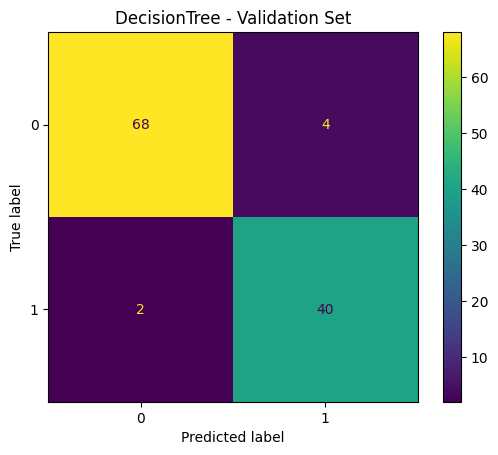

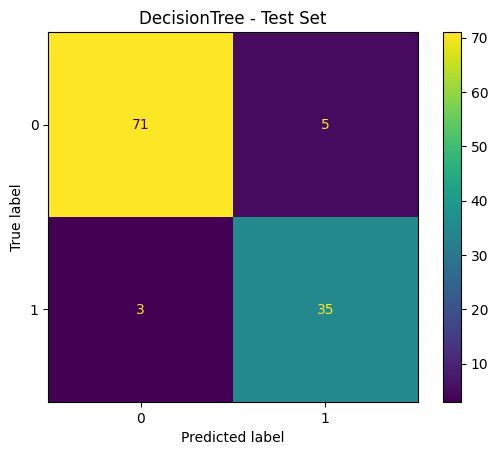


Visualization for RandomForest


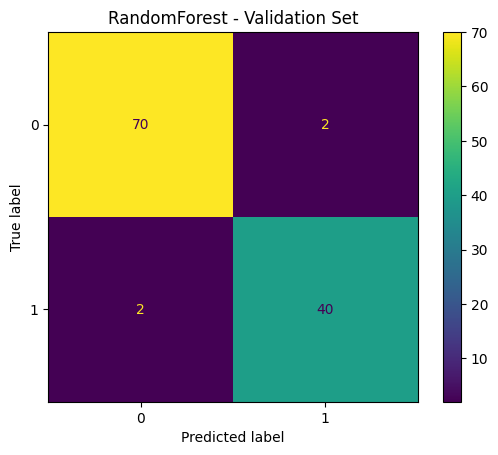

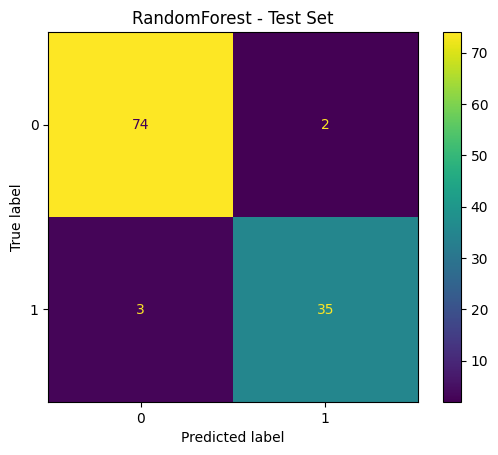


Visualization for AdaBoost


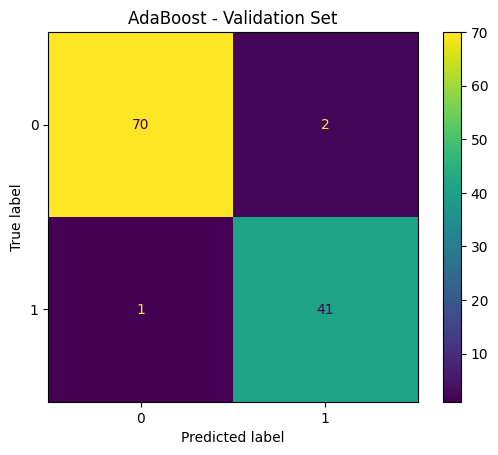

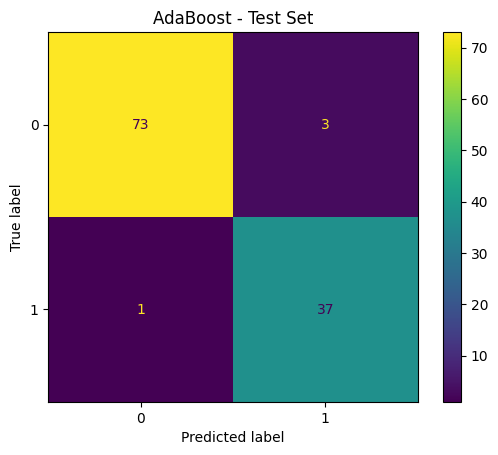


Visualization for GradientBoost


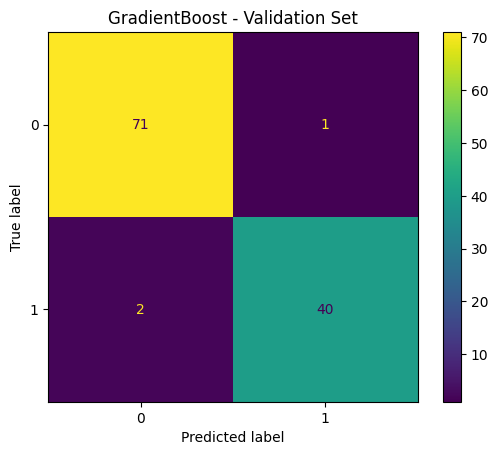

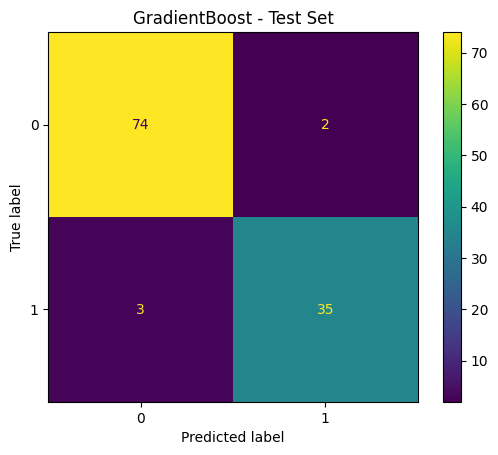


Visualization for XGBoost


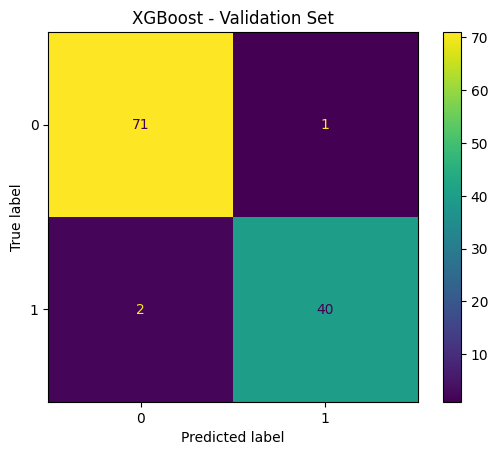

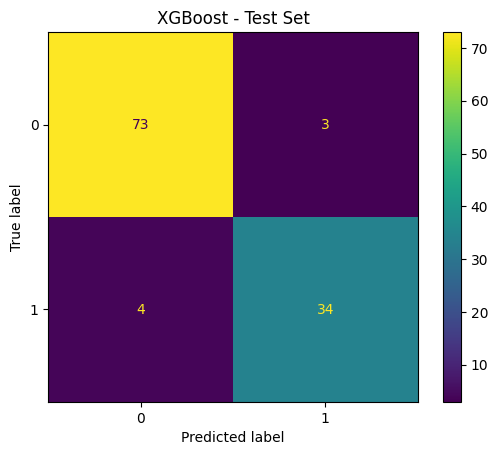


Visualization for Stacked_LogReg


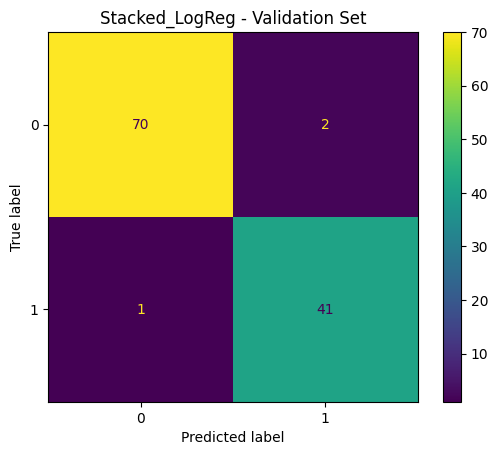

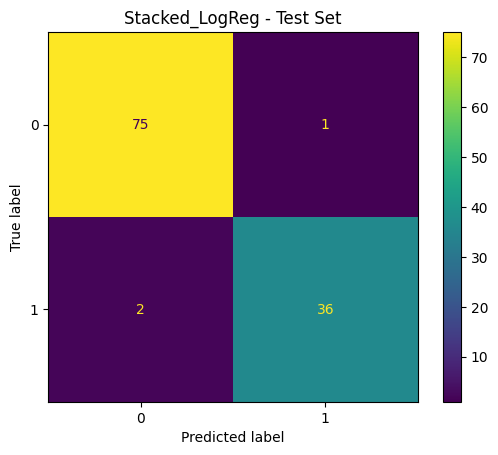


Visualization for Stacked_RF


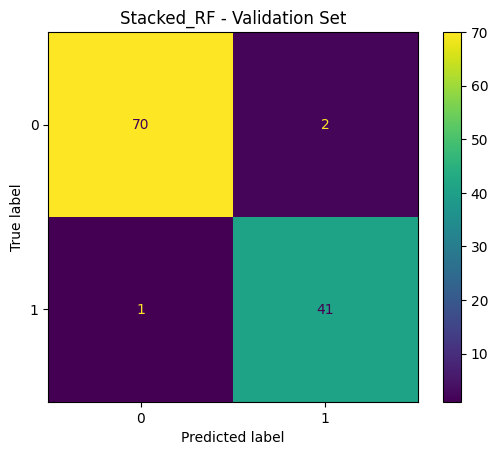

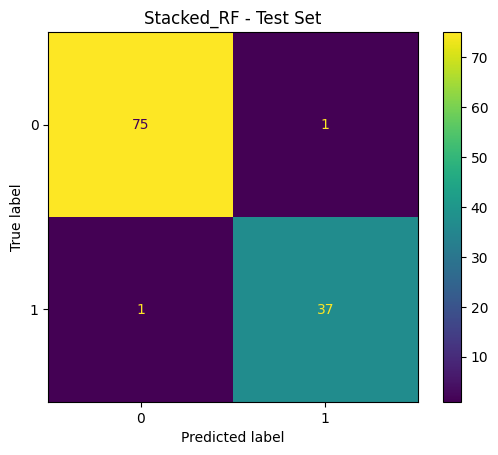


Visualization for Stacked_LogReg_KNN


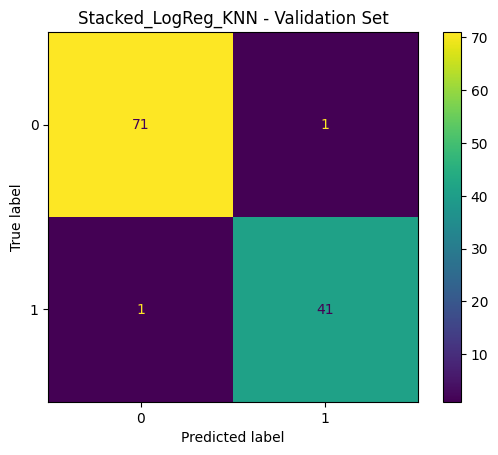

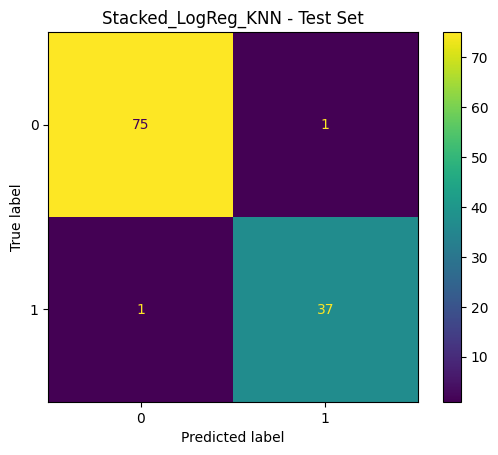

In [17]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()

for model_name in best_models.keys():
    print(f"\nVisualization for {model_name}")

    y_val_pred = y_val_preds[model_name]
    y_test_pred = y_test_preds[model_name]

    if not is_classification:
        # Validation plots
        plot_actual_vs_predicted(y_val, y_val_pred, f"{model_name} - Validation Set")
        plot_residuals(y_val, y_val_pred, f"{model_name} - Validation Set")
        plot_residual_distribution(y_val, y_val_pred, f"{model_name} - Validation Set")

        # Test plots
        plot_actual_vs_predicted(y_test, y_test_pred, f"{model_name} - Test Set")
        plot_residuals(y_test, y_test_pred, f"{model_name} - Test Set")
        plot_residual_distribution(y_test, y_test_pred, f"{model_name} - Test Set")

    else:
        # Confusion matrices
        plot_confusion_matrix(y_val, y_val_pred, f"{model_name} - Validation Set")
        plot_confusion_matrix(y_test, y_test_pred, f"{model_name} - Test Set")

In [18]:
# (vii) K-Fold Cross Validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
if is_classification:
    score = 'accuracy'
else:
    score = 'r2'

cv_results = {}

for model_name, model in best_models.items():
    print(f"\nCross-Validation for {model_name}")

    scores = cross_val_score(model, X, y, cv=kfold, scoring=score)

    cv_results[model_name] = scores

    print("Cross Validation Scores:", scores)
    print("Average CV Score:", round(scores.mean(), 4))


Cross-Validation for DecisionTree
Cross Validation Scores: [0.92105263 0.95614035 0.9122807  0.9122807  0.91150442]
Average CV Score: 0.9227

Cross-Validation for RandomForest
Cross Validation Scores: [0.95614035 0.97368421 0.96491228 0.95614035 0.94690265]
Average CV Score: 0.9596

Cross-Validation for AdaBoost
Cross Validation Scores: [0.95614035 0.97368421 0.95614035 0.98245614 0.96460177]
Average CV Score: 0.9666

Cross-Validation for GradientBoost
Cross Validation Scores: [0.95614035 0.98245614 0.96491228 0.97368421 0.94690265]
Average CV Score: 0.9648

Cross-Validation for XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:02:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:02:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:02:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:02:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:02:00] WARNING: /w

Cross Validation Scores: [0.95614035 0.99122807 0.95614035 0.98245614 0.9380531 ]
Average CV Score: 0.9648

Cross-Validation for Stacked_LogReg
Cross Validation Scores: [0.97368421 0.99122807 0.96491228 0.97368421 0.94690265]
Average CV Score: 0.9701

Cross-Validation for Stacked_RF
Cross Validation Scores: [0.96491228 0.98245614 0.95614035 0.92982456 0.9380531 ]
Average CV Score: 0.9543

Cross-Validation for Stacked_LogReg_KNN
Cross Validation Scores: [0.97368421 0.99122807 0.94736842 0.97368421 0.96460177]
Average CV Score: 0.9701
